In [1]:
import lasio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from prov import identifier

import view_well_file
import interpolation

mpl.rcParams.update({'font.size':20})

In [2]:
import importlib
importlib.reload(view_well_file)


<module 'view_well_file' from 'C:\\Users\\petka\\Jupyter\\FART_CENTER\\view_well_file.py'>

In [3]:
DATA_DIR = "data\\las"
EXCEL_DIR = "data"

In [4]:
well_idx = []

In [5]:
for filename in os.listdir(DATA_DIR):
    # Print each filename
    well_idx.append(filename.split("_")[0])
    # print(filename)

In [6]:
well_idx = set(well_idx)

In [7]:
len(well_idx)

41

In [8]:
type(list(well_idx)[0])

str

In [9]:
excel = pd.read_excel(EXCEL_DIR + "\\Отбивки пласта АС11-2.xlsx")

In [10]:
upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [11]:
lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [12]:
target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]


In [13]:
target_layers

,Well identifier,upper,lower
1,12,-2161.95,-2183.98
2,13,-2158.72,-2175.36
3,14,-2170.38,-2190.59
4,15,-2170.84,-2188.69
5,16,-2157.70,-2178.94
6,17,-2150.80,-2171.09
7,18,-2146.87,-2167.39
8,19,-2129.24,-2150.87
9,20,-2141.56,-2162.04
10,22,-2129.92,-2146.85


In [14]:
target_layers.iloc[30]

Well identifier         44
upper             -2128.99
lower             -2145.62
Name: 32, dtype: object

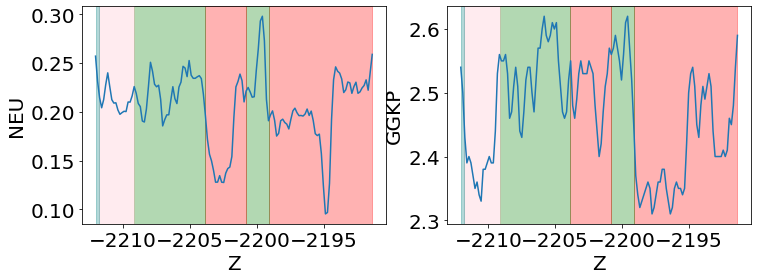

In [15]:
z, ggkp, neu = view_well_file.view_well(20, target_layers)

In [130]:
z.shape

(137,)

In [222]:
width = 6
z_interp, ggkp_interp = interpolation.interpolate_lin_av(z, ggkp, 200, width)
z_interp1, ggkp_interp1 = interpolation.interpolate_lin_av(z, ggkp, 100, width)
z_interp2, ggkp_interp2 = interpolation.interpolate_lin_av(z, ggkp, 50, width)

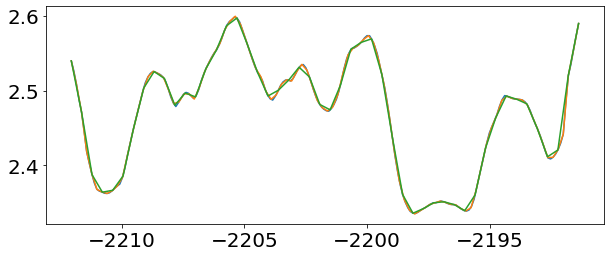

In [132]:
plt.figure(figsize=(10, 4))
plt.plot(z_interp, ggkp_interp)
plt.plot(z_interp1, ggkp_interp1)
plt.plot(z_interp2, ggkp_interp2)
plt.show()

189.1076115485545


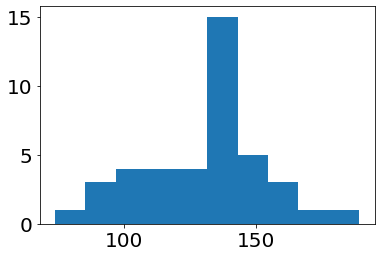

In [133]:
plt.hist((target_layers.upper - target_layers.lower) / 0.1524)
print(max((target_layers.upper - target_layers.lower) / 0.1524))
plt.show()

In [281]:
data = []

interpol_func = interpolation.interpolate_lin_av
new_size = 100


for well_index in range(len(well_idx)):
    well_name = target_layers.iloc[well_index]['Well identifier']
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpol_func(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], new_size, width)
    data.append(np.stack(data_interp))
    
    '''plt.figure(figsize = (15, 10))
    plt.plot(data_interp[0], data_interp[1], label = well_name)
    plt.ylabel('GGKP')
    plt.xlabel('Z, m')
    plt.grid()
    plt.legend()
    plt.savefig('ggkp_pics\\'+str(well_name)+'.png')
    plt.show()'''

'''data = np.empty(len(data_), dtype=object)
for i, sublist in enumerate(data_):
    data[i] = np.array(sublist)

data = np.vstack(data)'''

'data = np.empty(len(data_), dtype=object)\nfor i, sublist in enumerate(data_):\n    data[i] = np.array(sublist)\n\ndata = np.vstack(data)'

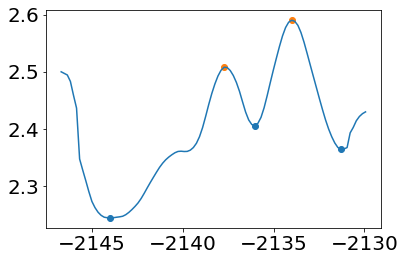

In [192]:
test_data = np.array(data_)[9, ...].copy()
test_data[1] = interpolation.average(test_data[1], 6)
peak_width = 4

min_idx, max_idx = [], []

for i in range(peak_width, test_data.shape[1] - peak_width):
    if (test_data[1][i] >= test_data[1][i-peak_width:i]).all() and (test_data[1][i] >= test_data[1][i:i+peak_width]).all():
        max_idx.append(i)
    if (test_data[1][i] <= test_data[1][i-peak_width:i]).all() and (test_data[1][i] <= test_data[1][i:i+peak_width]).all():
        min_idx.append(i)

plt.plot(test_data[0], test_data[1])
plt.scatter(test_data[0][min_idx], test_data[1][min_idx])
plt.scatter(test_data[0][max_idx], test_data[1][max_idx])

In [258]:
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [290]:
data = np.array(data)
print(data.shape)
new_data = np.empty((41,101))
for i in range(41):
    new_data[i] = np.concatenate([[data[i, 0].mean()], data[i, 1]])
    new_data[i] -= new_data[i].mean()
    new_data[i] /= new_data[i].max()-new_data[i].min()
new_data.shape, data.shape

(41, 2, 100)


((41, 101), (41, 2, 100))

For n_clusters = 2 The average silhouette_score is : 0.14010261881628044
For n_clusters = 3 The average silhouette_score is : 0.13279955443423097
For n_clusters = 4 The average silhouette_score is : 0.1450460066717093
For n_clusters = 5 The average silhouette_score is : 0.16830149183409238
For n_clusters = 6 The average silhouette_score is : 0.14961155436126156
For n_clusters = 7 The average silhouette_score is : 0.17265455478017283
For n_clusters = 8 The average silhouette_score is : 0.17534685965664296
For n_clusters = 9 The average silhouette_score is : 0.15475183161191883
For n_clusters = 10 The average silhouette_score is : 0.15108061920777927
For n_clusters = 11 The average silhouette_score is : 0.13942810776061956
For n_clusters = 12 The average silhouette_score is : 0.1482270648668912
For n_clusters = 13 The average silhouette_score is : 0.13533384430368556
For n_clusters = 14 The average silhouette_score is : 0.11903440107705902
For n_clusters = 15 The average silhouette_score

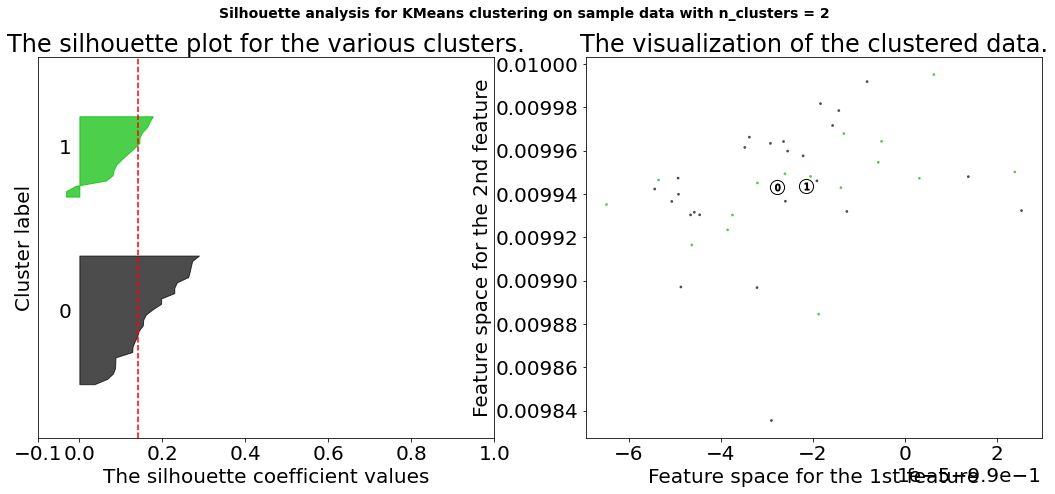

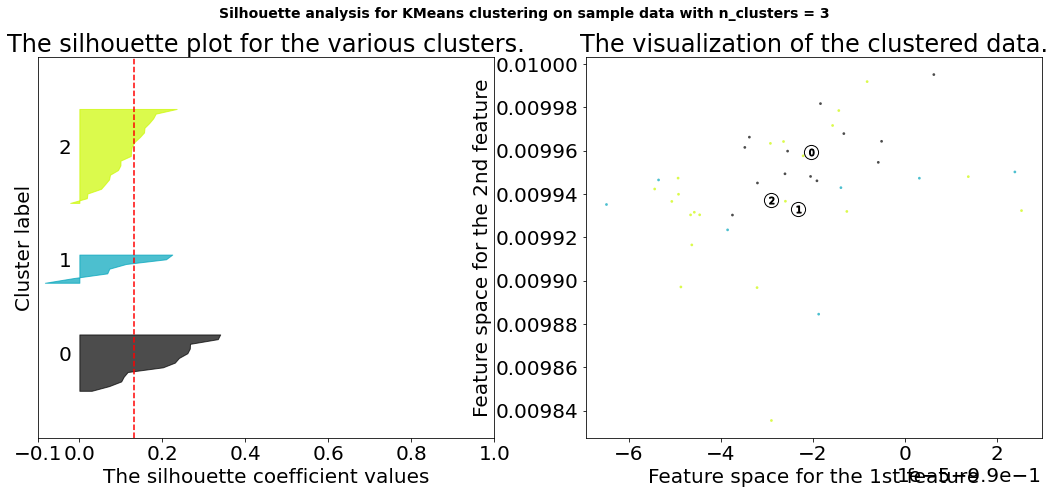

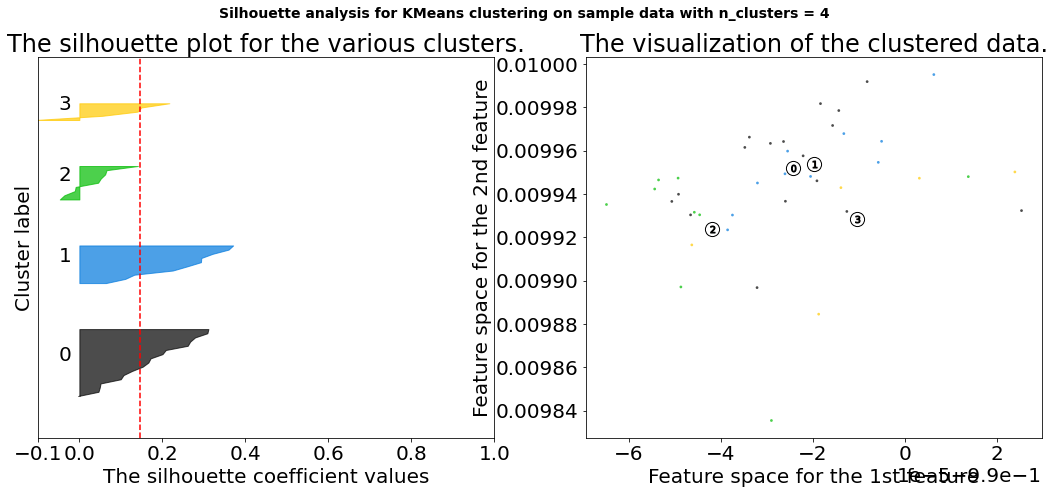

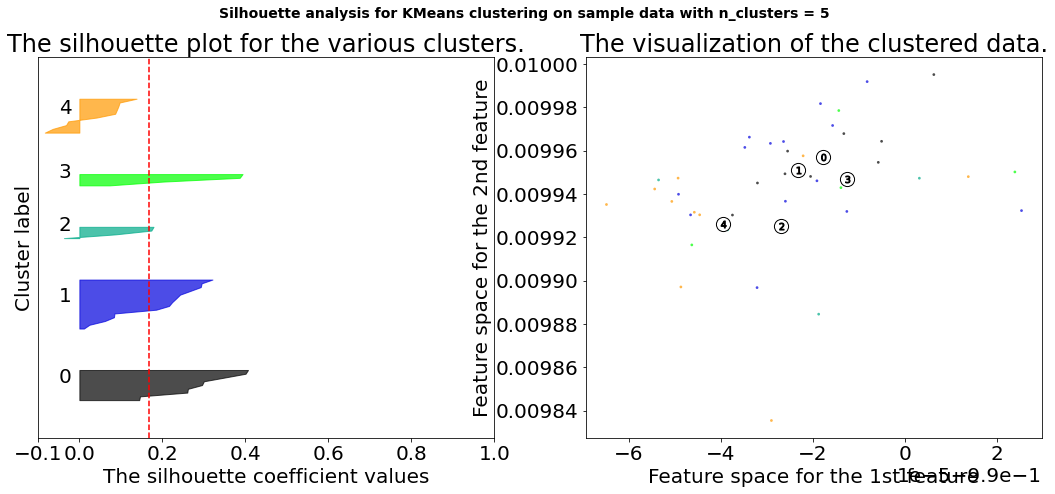

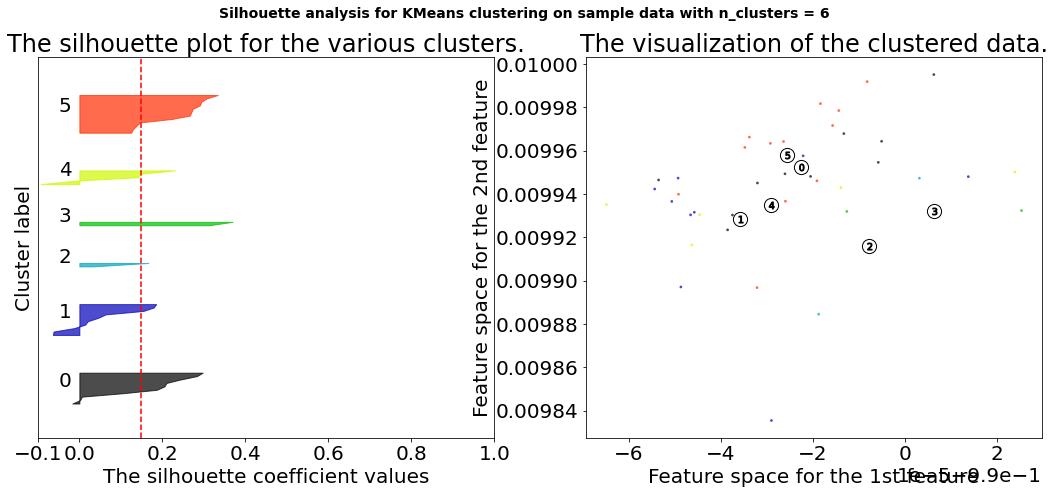

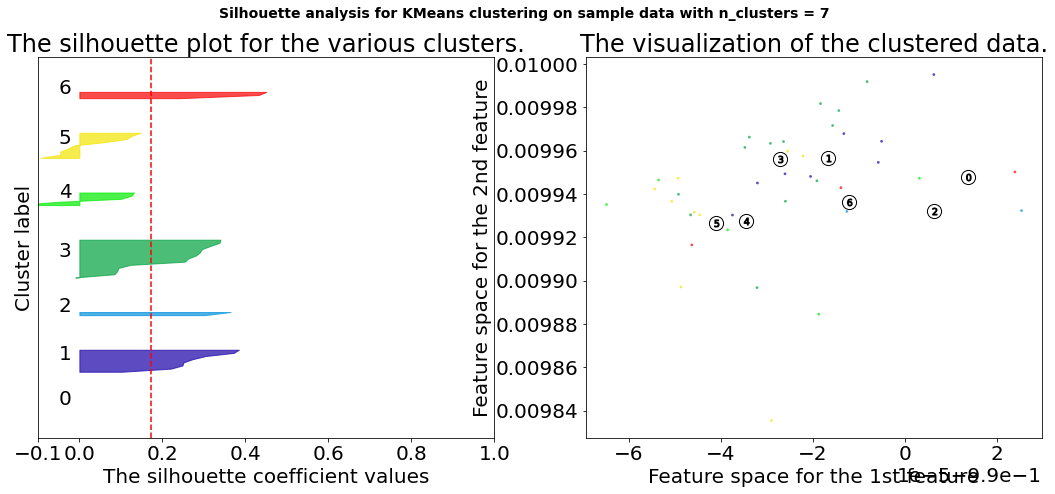

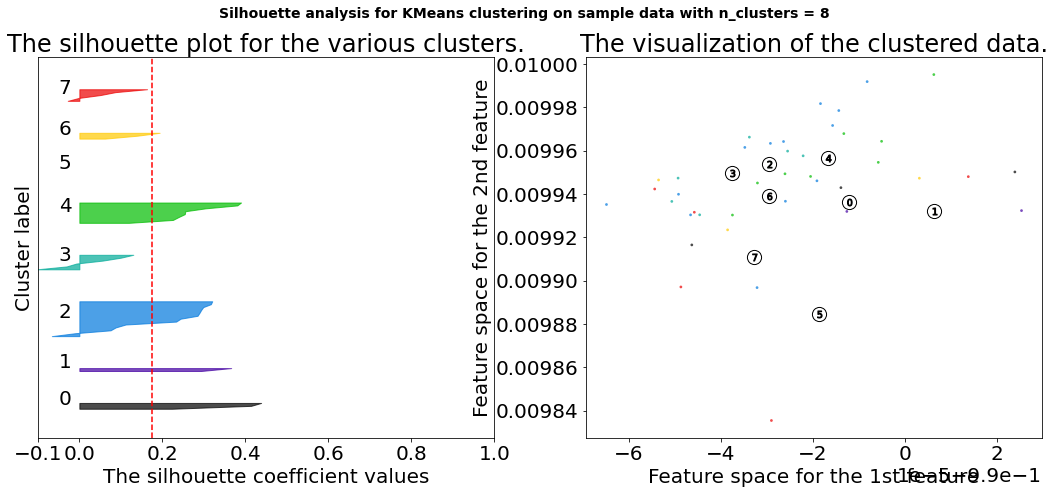

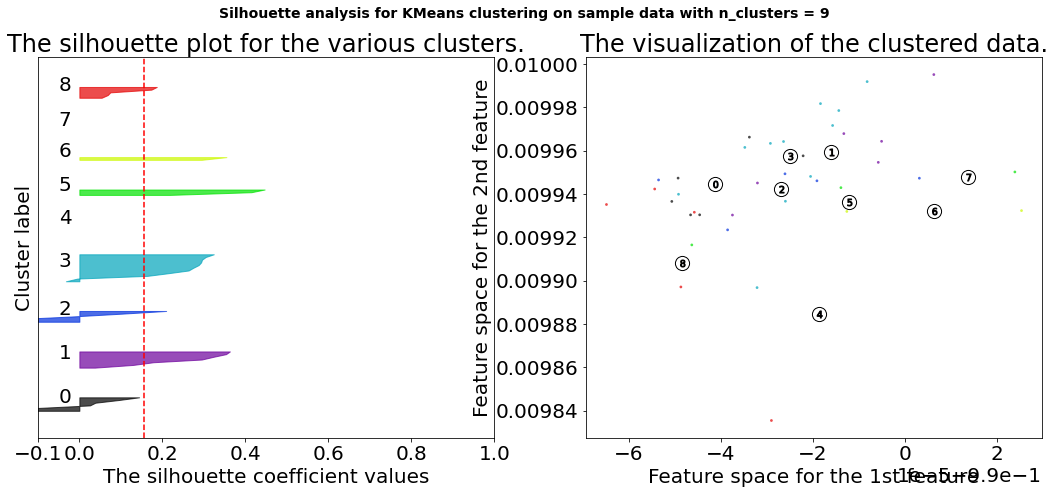

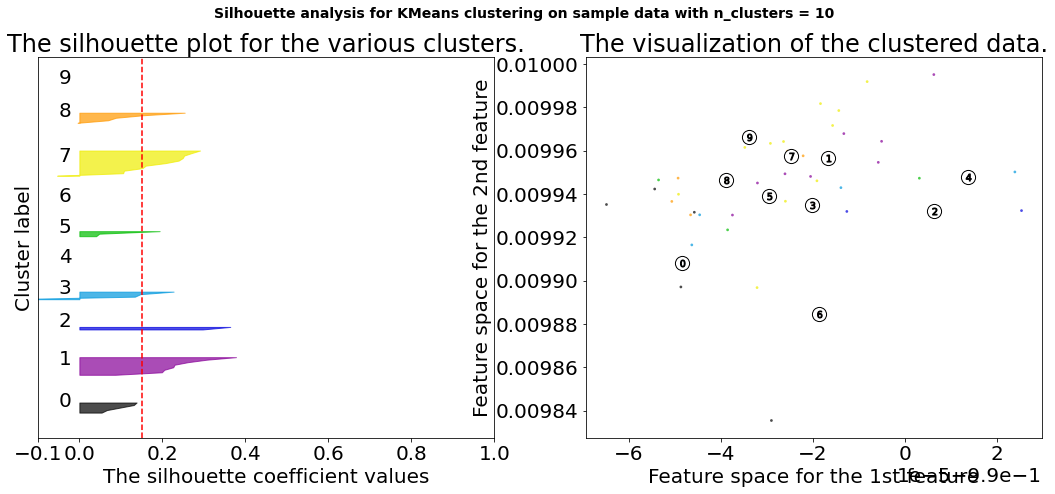

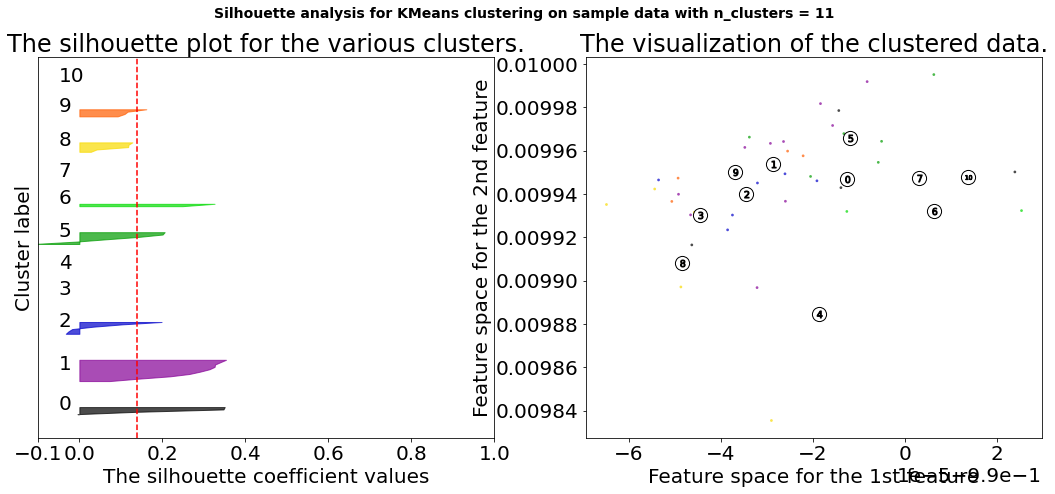

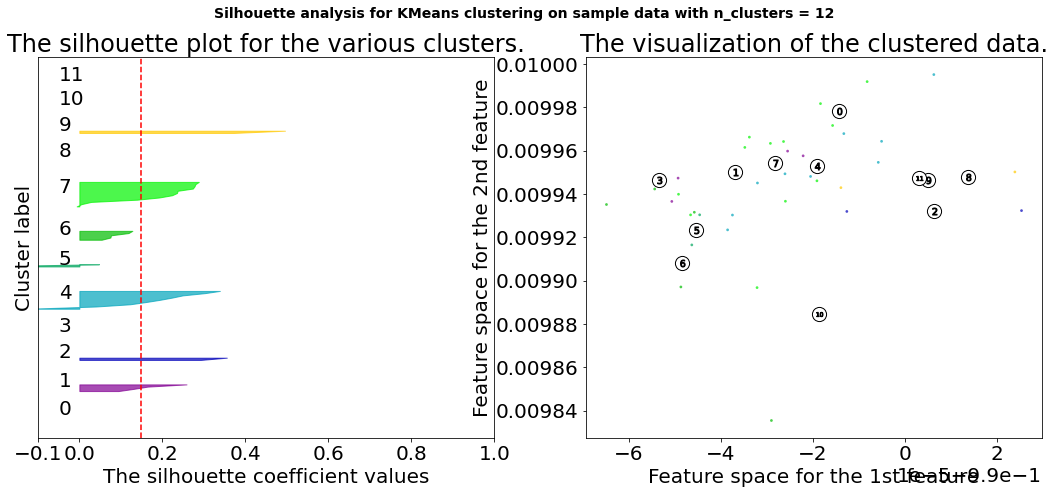

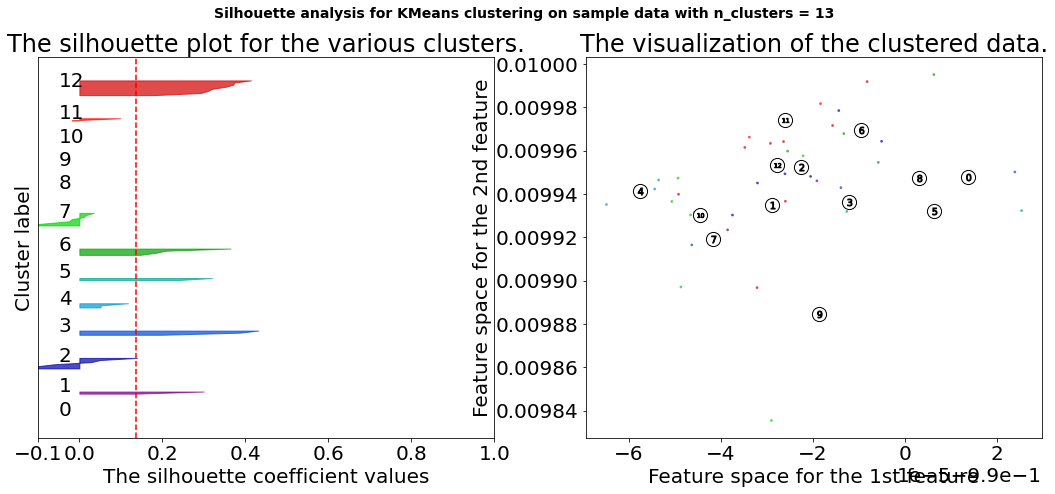

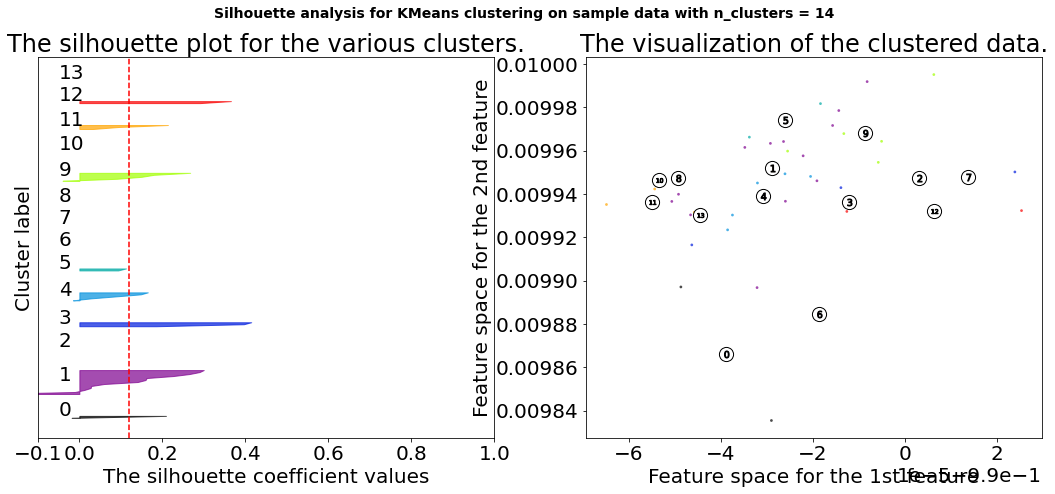

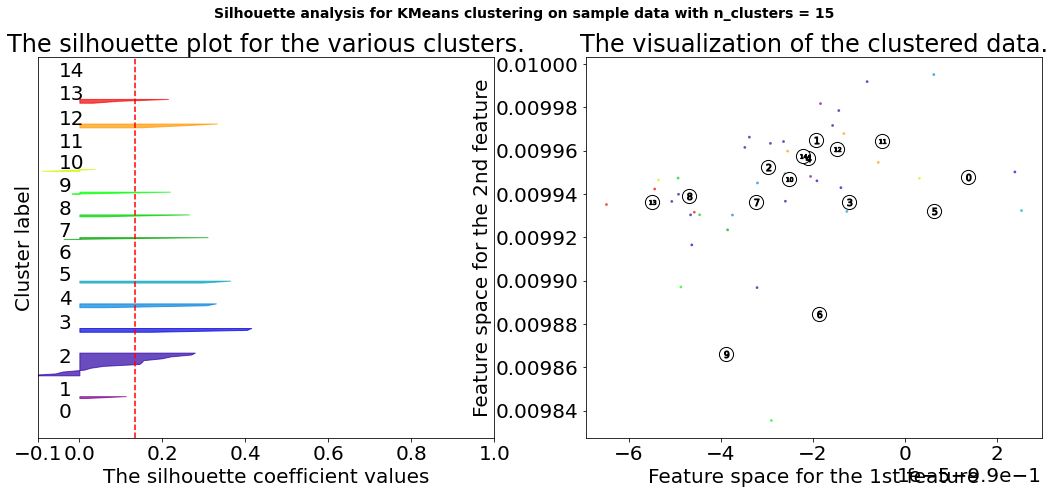

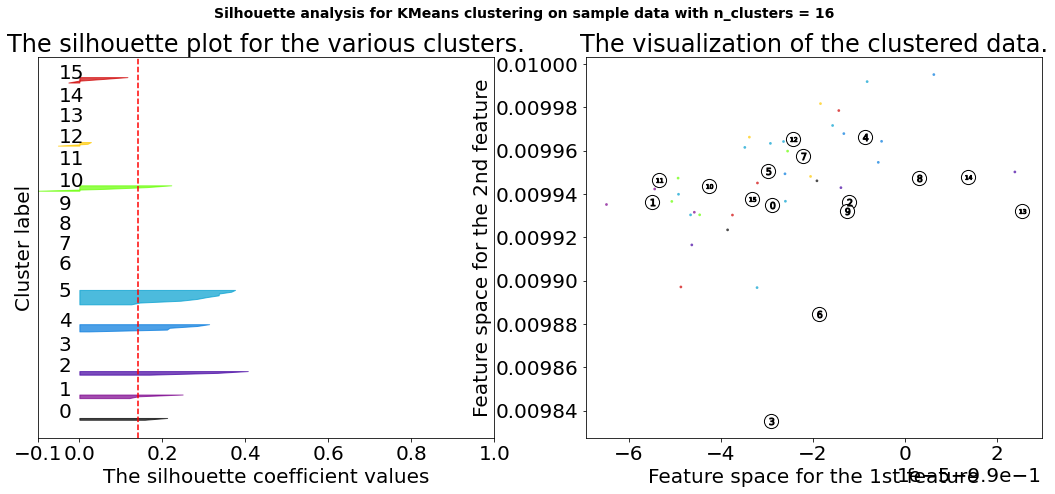

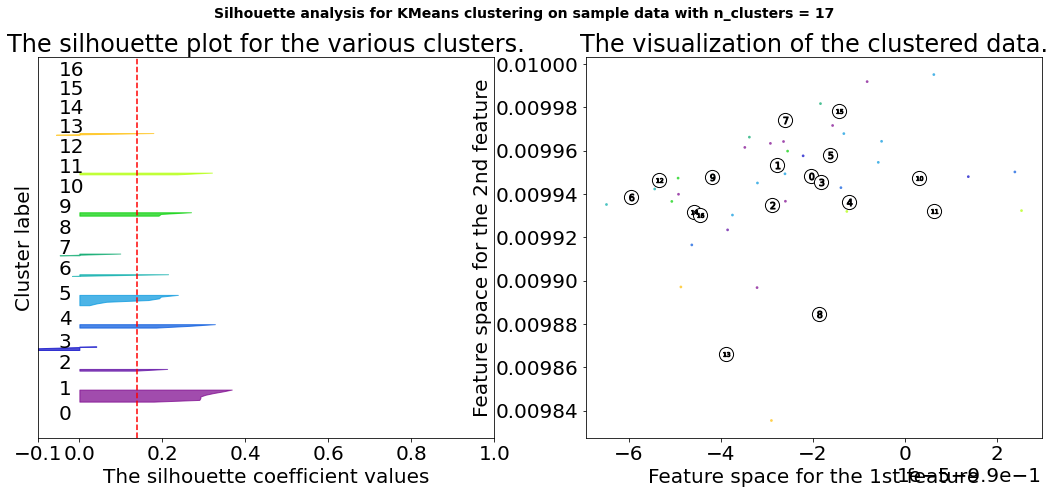

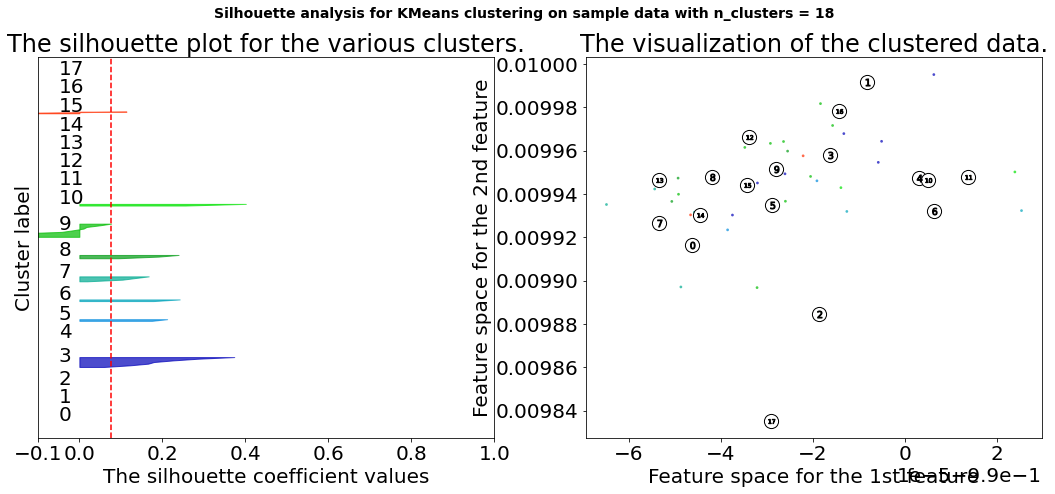

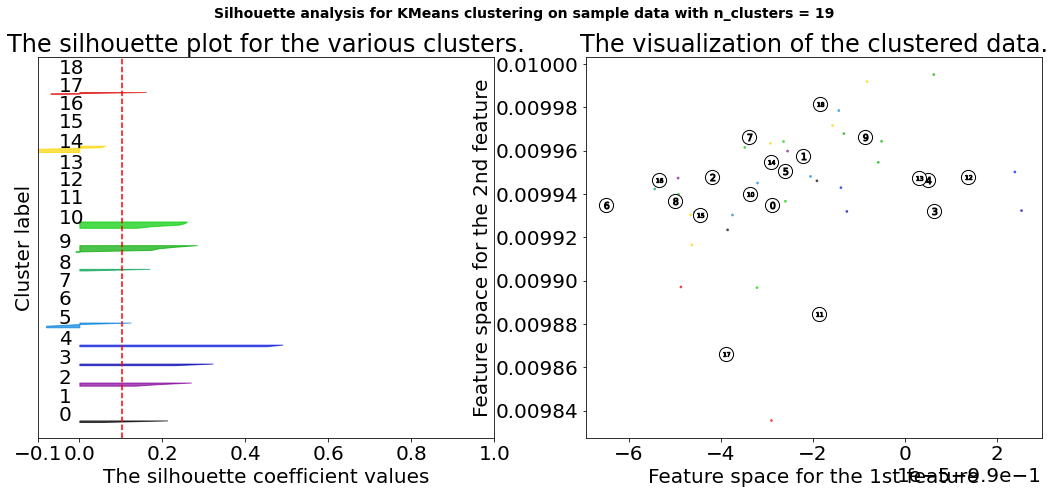

In [291]:
X = new_data#[:, 1, :]

range_n_clusters = list(range(2,20))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [292]:
n_clusters = 8
#for n_clusters in range(2, 10):
cluster_alg = KMeans(n_clusters)
cluster_alg.fit(new_data)
#print(cluster_alg.labels_)
print('Number of clusters is', n_clusters, 'and silhouette score is', silhouette_score(new_data, cluster_alg.labels_))

Number of clusters is 8 and silhouette score is 0.17763705524737156


In [294]:
!mkdir 1 2 3 4 5 6 7 8 9 0
#!rm 1/* 2/* 3/* 4/* 5/* 6/* 7/* 8/* 9/* 0/*

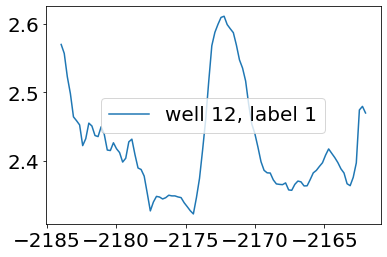

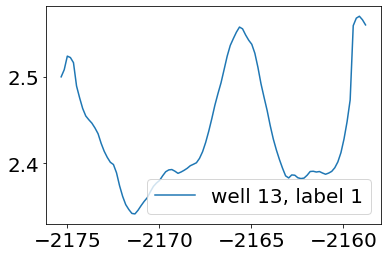

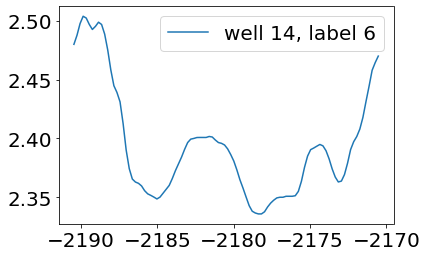

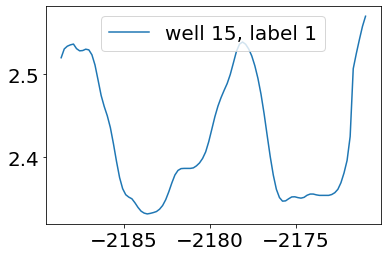

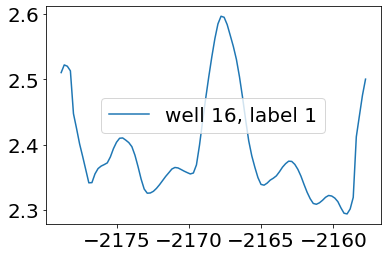

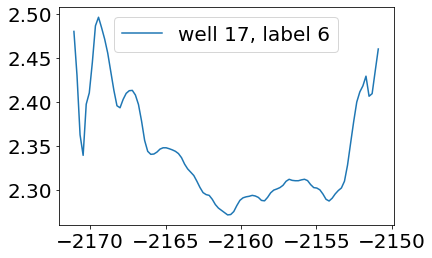

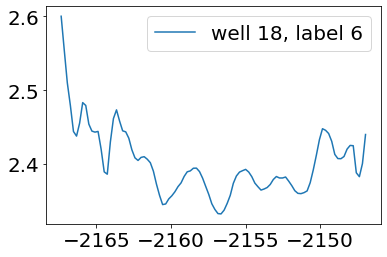

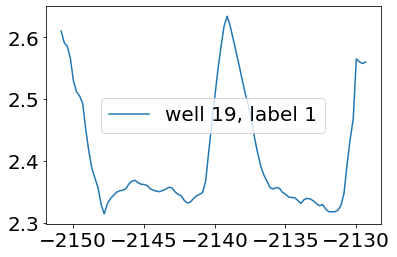

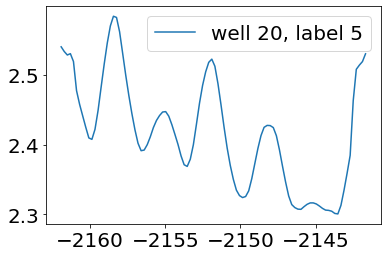

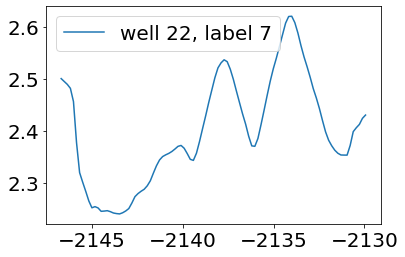

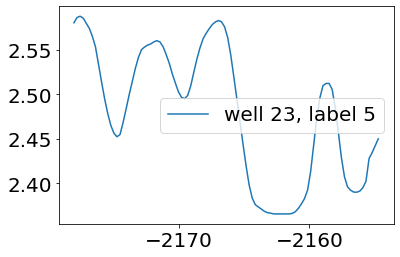

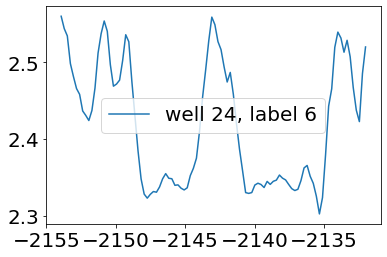

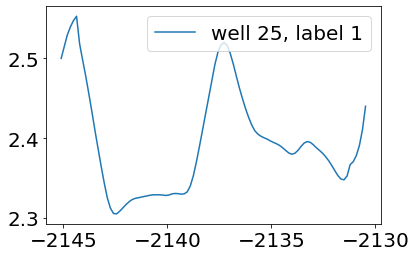

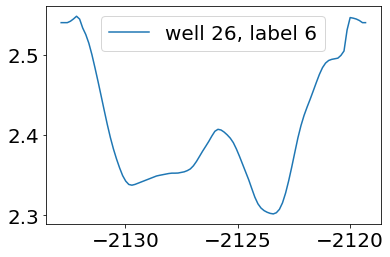

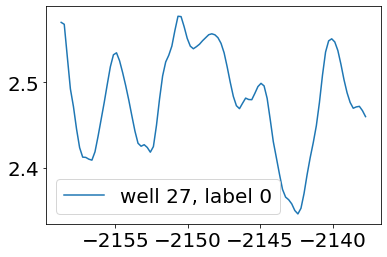

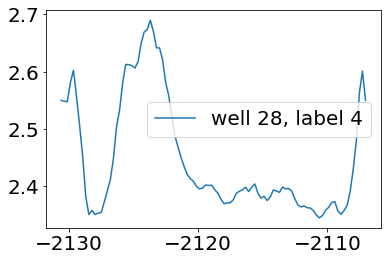

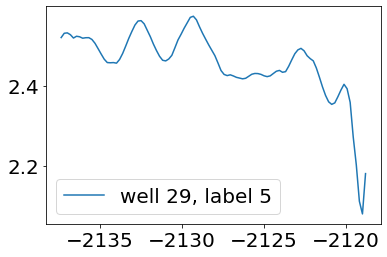

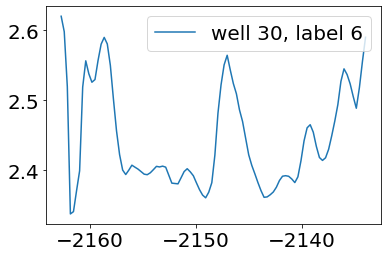

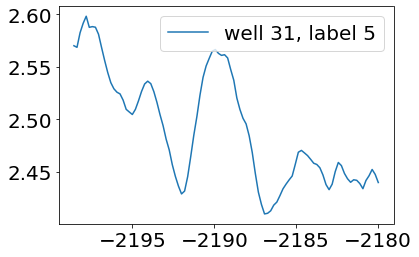

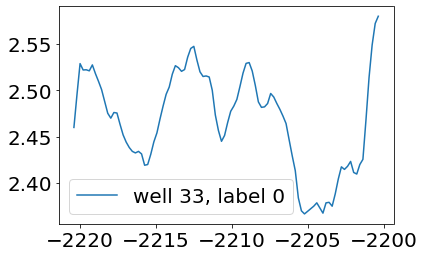

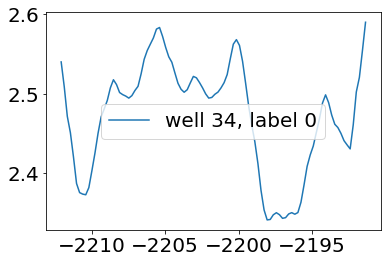

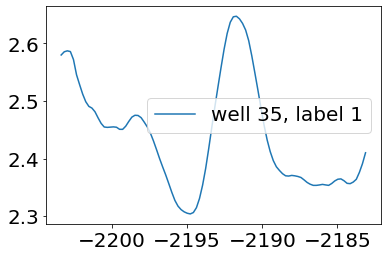

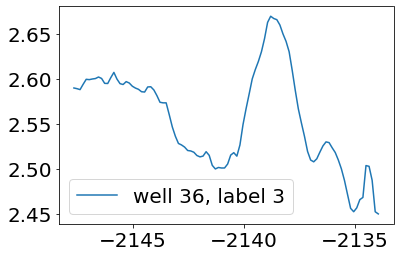

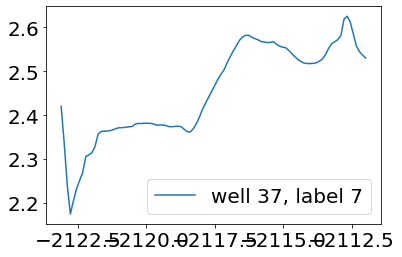

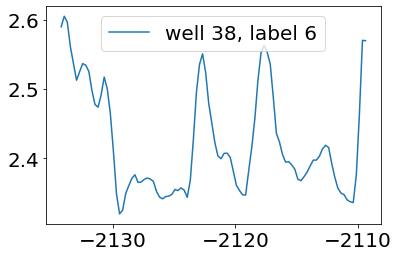

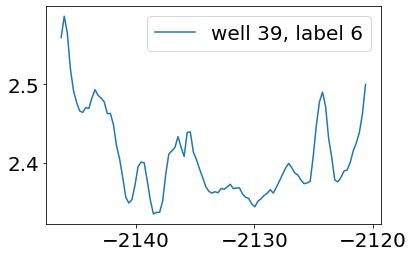

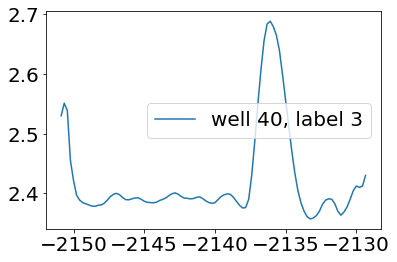

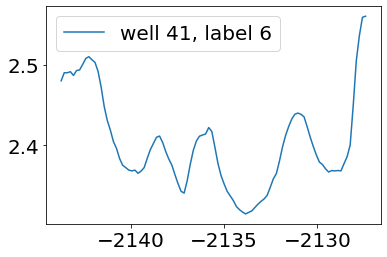

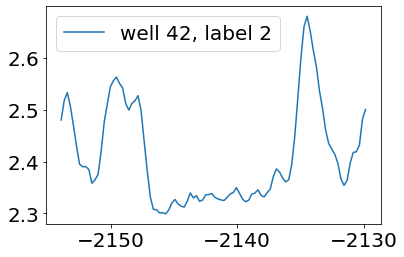

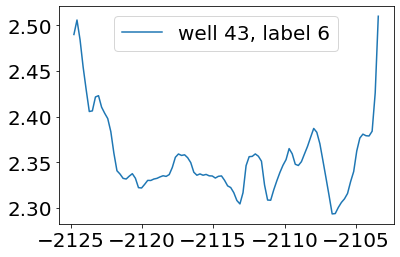

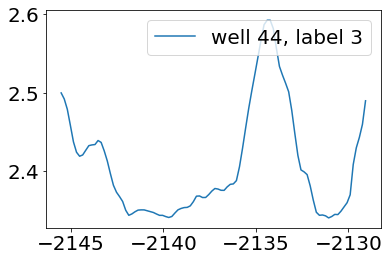

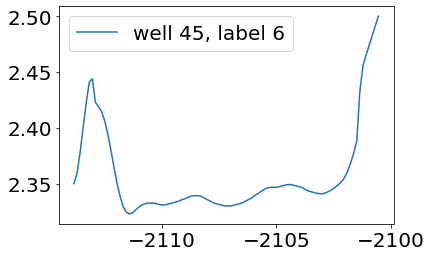

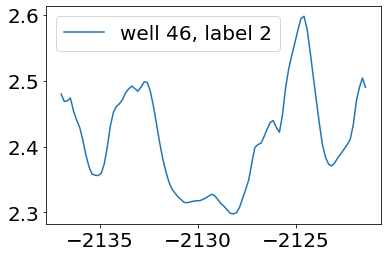

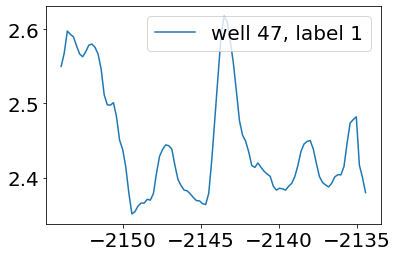

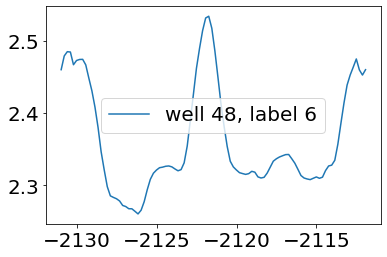

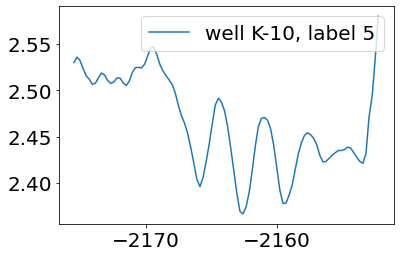

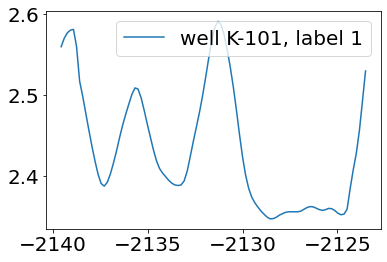

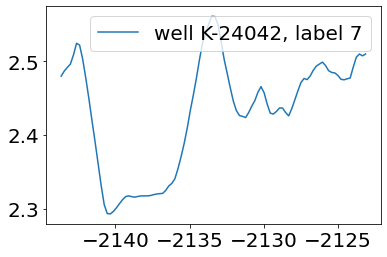

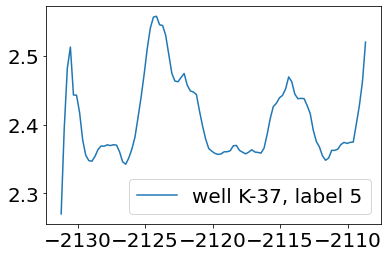

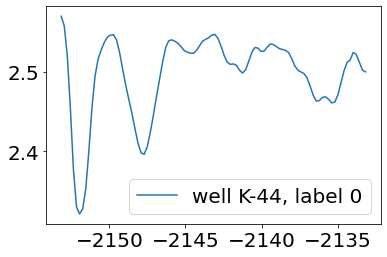

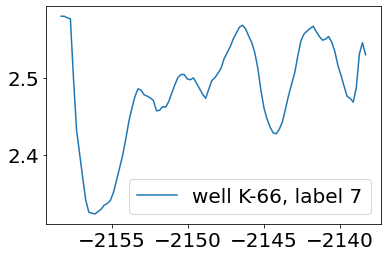

In [295]:
for i in range(data.shape[0]):
    plt.plot(data[i, 0], data[i, 1], label = 'well '+str(target_layers.iloc[i]['Well identifier'])+', label '+str(cluster_alg.labels_[i]))
    plt.legend()
    plt.savefig(str(cluster_alg.labels_[i])+'/'+str(target_layers.iloc[i]['Well identifier'])+'.png')
    plt.show()